# Covid19 - Exploratory data analysis
**Table of contents:**
* Importing dependecies
* Basic data manipulation - grouping, aggregating etc.
* Model building

In [12]:
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.arima_model import ARIMA

In [2]:
# Getting all the files in "data" directory 
list_of_files = os.walk('./data/')
list_of_files = list(list_of_files)[0][2]

# For EDA purposes I am going to use only one country as a template
DIR = './data/'
COUNTRY = 'poland.csv'

In [3]:
dataset = pd.read_csv(DIR + COUNTRY)

In [4]:
dataset.head()

,Unnamed: 0,Date,Cases
0,0,2020-03-04,1
1,1,2020-03-05,1
2,2,2020-03-06,5
3,3,2020-03-07,5
4,4,2020-03-08,11


In [5]:
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
dataset['Date'] = pd.to_datetime(dataset['Date'])

I am interested in prediciting not only *total cases* but also **new cases**, however dataset only contains *total cases* for each day. Luckly this provides enough information to **new cases**. We know that new cases is just the difference between day **n+1** and **n**. We can use a formula: ***NewCases*** = **TotalCases(n+1)** - **TotalCases(n)**. For the last row in the dataset NewCases is going to be undefined, becouse we don't have **TotalCases(n+1).**

In [6]:
# this loop implements formula from above
new_cases = []
for n in range(dataset.shape[0]):
    try:
        new_cases.append(dataset['Cases'][n+1] - dataset['Cases'][n])
    except KeyError:
        # new_cases.append(np.NaN) - would contain nan, so let's just pass
        pass

In [7]:
# Now let's drop last row becouse it contains a NaN
dataset.drop(dataset.tail(1).index, inplace=True)

In [8]:
dataset['New_cases'] = new_cases
dataset = dataset.rename(columns={'Cases' : 'Total_cases'})
dataset.head()

,Date,Total_cases,New_cases
0,2020-03-04,1,0
1,2020-03-05,1,4
2,2020-03-06,5,0
3,2020-03-07,5,6
4,2020-03-08,11,5


At the moment *date* column has a frequency of one day - in practice when we look at time series data we should be more concerned with *longer* periods of time such as weeks or months if not years in some cases. **Pandas** *groupby* is ideal for such case.

In [9]:
dataset = dataset.groupby(pd.Grouper(key='Date',freq='W-MON')).agg({'Total_cases':'sum', 'New_cases':'sum'})
dataset = dataset.reset_index()

In [10]:
dataset.head()

,Date,Total_cases,New_cases
0,2020-03-09,39,21
1,2020-03-16,569,216
2,2020-03-23,3188,663
3,2020-03-30,10117,1410
4,2020-04-06,23336,2537


**Now our data in nicely organized :)**

**Let's move on to data visualiaztion.**

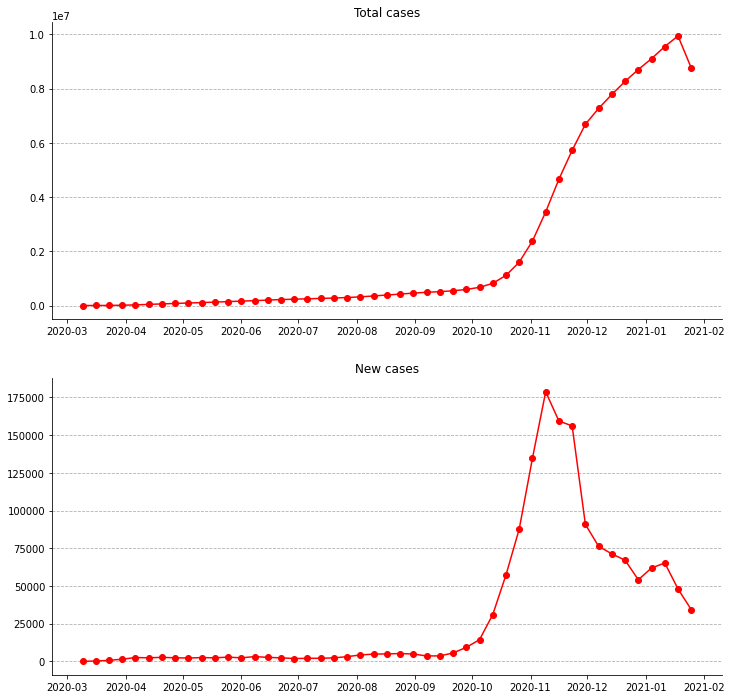

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))

ax[0].plot(dataset['Date'], dataset['Total_cases'], 
           marker='o', 
           color='red')
ax[0].set_title('Total cases')
ax[1].plot(dataset['Date'], dataset['New_cases'], 
           marker='o', 
           color='red')
ax[1].set_title('New cases')

for i in range(2):
    for k in ['top', 'right']:
        ax[i].spines[k].set_visible(False)

    ax[i].spines['left'].set_color('black')
    ax[i].spines['bottom'].set_color('black')
    
    ax[i].grid(axis='y', linestyle='dashed')
    ax[i].xaxis.grid(False)
    
# plt.savefig('sample_chart.png')
plt.show()

**Curves represent sum of new/total cases per week.**

Total cases is of course an exponential curve and over a long period of time it's change isn't very drastic. New cases on the other hand is much more unstable. WATCH https://www.youtube.com/watch?v=Kas0tIxDvrg&t=0s. 

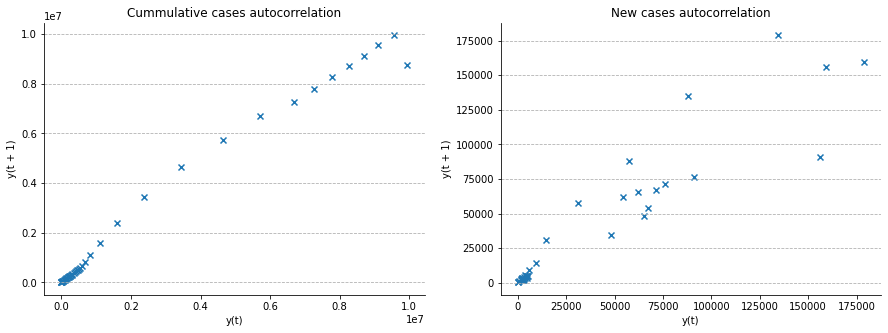

In [36]:
figure, ax = plt.subplots(1, 2, figsize=(15,5))

lag_plot(dataset['Total_cases'], ax=ax[0], marker='x')
ax[0].set_title('Cummulative cases autocorrelation')
lag_plot(dataset['New_cases'], ax=ax[1], marker='x')
ax[1].set_title('New cases autocorrelation')

for i in range(2):
    for k in ['top', 'right']:
        ax[i].spines[k].set_visible(False)

    ax[i].spines['left'].set_color('black')
    ax[i].spines['bottom'].set_color('black')
    
    ax[i].grid(axis='y', linestyle='dashed')
    ax[i].xaxis.grid(False)